# Trade-off entre sesgo y varianza

En este notebook vamos a explorar los conceptos de sesgo y varianza en Machine Learning, y el trade-off que existe entre ellos.

##  1. Preliminares

En este notebook vamos a trabajar en un problema de regresión con datos de entrenamiento generados artificialmente. Para ajustar un modelo a esos datos, utilizaremos la regresión lineal. Sin embargo, la relación entre `x` e `y` NO será lineal, por lo que tendremos que hacer un poco de manejo de features para lograrlo. Para entender la idea, veamos el siguiente ejemplo.

$$ y  = 1 - 3x + 5x^2 $$

La relación entre $x$ e $y$ no es lineal, pero si a partir de $x$ creamos un nuevo atributo $x_1 = x^2$, ahora tenemos 

$$ y  = 1 - 3x + 5x_1 $$

Entonces, lo que hicimos fue convertir un problema no lineal de una variable en un problema lineal de dos variables. ¿Les suena parecido a algo que hayamos visto?

En general, nosotros no conocemos la relación funcional entre los features ($x$) y la variable que queremos predecir ($y$). Entonces, lo que hacemos es *probar* agregando muchos features nuevos, elevando al cuadrado, al cubo, a la cuarta, etc. Pero llega un momento donde corremos el riesgo de sobreajustar nuestros datos: matemáticamente, si tenemos $n$ datos, podemos ajustar un polinomio de grado $n-1$ a ellos perfectamente. Es decir, la cantidad de features nuevos que creemos y la potencia más alta a la que elevaremos $x$ es un **hiperparámetro**.

En Python, es sencillo hacer este ajuste utilizando la [matriz de Vandermonde](https://es.wikipedia.org/wiki/Matriz_de_Vandermonde). Ésta es una matriz que, dado un vector $x$, tiene en cada columna la potencia de ese vector. Por ejempo

In [23]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
x1 = np.array([1,2,3])
np.vander(x1,N = 4, increasing = True)

array([[ 1,  1,  1,  1],
       [ 1,  2,  4,  8],
       [ 1,  3,  9, 27]])

**Para pensar y probar:** Si `N = 5`, ¿hasta qué potencia eleva al vector?¿Qué ocurre si ponen `increasing = False`?

Notar que la matriz de Vandermonde ya devuelve un arreglo al cual Scikit-Learn puede usar como features.

**Ejercicio:** Prestar atención a las siguientes funciones. ¿Qué hacen? Utilizarlas para implementar el ejemplo de la explicación, con 100 valores de `x` entre -2 y 2. Visualizar.

In [34]:
from sklearn.linear_model import LinearRegression

def fit_polynomial(x, y, degree):
    model = LinearRegression()
    model.fit(np.vander(x, degree + 1), y)
    return model

def apply_polynomial(model, x):
    degree = model.coef_.size - 1
    y = model.predict(np.vander(x, degree + 1))
    return y

In [26]:
x = np.linspace(-2,2,100)
y = 1 - 3*x + 5*x**2

In [27]:
model = fit_polynomial(x, y, 2)
p_y = apply_polynomial(model, x)
print(model.coef_)

[ 5. -3.  0.]


In [28]:
plt.plot(x, y, label = 'Datos')
plt.plot(x, p_y, 'k.', label = 'Ajustado')
plt.legend()
plt.show()

## 2. Generación de datos de entrenamiento

Ahora, vamos a generar los datos de entrenamiento con los que trabajaremos. Trabajaremos en un problema de regresión, del cual conoceremos la forma funcional entre las variables `x` e `y`:

$$ y  = 2sin(1.5x) $$

**Ejercicio:** escribir una función `sample` que genere muestras **con ruido gaussiano** de esta función. Sus argumentos deben ser `x_min`, `x_max` y `size`, que representan el mínimo y máximo del rango de `x` y la cantidad de muestras a obtener. Luego, graficar las muestras obtenidas y graficar una curva que represente la función **sin ruido**.

In [29]:
def sample(x_min, x_max, size):
    x = np.linspace(x_min, x_max, size)
    y = 2 * np.sin(x * 1.5) + np.random.randn(size)
    return (x,y)

In [30]:
x, y = sample(x_min = 0, x_max = 4.5, size = 50)
f_x = np.linspace(0, 4.5, 50)
f_y = 2 * np.sin(x * 1.5)

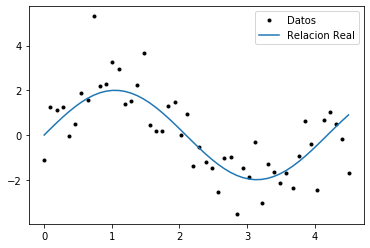

In [31]:
plt.plot(x,y, 'k.', label = 'Datos')
plt.plot(f_x, f_y, label = 'Relacion Real')
plt.legend()
plt.show()

## 3. Sesgo y Varianza

**Ejercicio:** ajustar los datos obtenidos con un polinomio de grado uno (lineal), grado dos (cuadrática) y grado tres (cúbica). Graficar. **Pista:** si lo hacen dentro de un `for`, ¡es muy sencillo!

**Para pensar y probar:** ¿cuál modelo dependerá más de los datos de entrenamiento?¿Y si ajustan un polinomio de grado mayor? Volver a generar datos de entrenamiento y ver qué cambia.

In [39]:
grados = [1,2,3]

In [40]:
plt.plot(x, f_y,'--', label =  'modelo')
plt.plot(x, y, 'k.', label =  'datos')

for grado in grados:
    model = fit_polynomial(x, y, grado)
    p_y = apply_polynomial(model, x)
    plt.plot(x, p_y, label = grado)
    
plt.legend()
plt.show()

### Promedio de modelos

Para hacer más evidente la dependencia (o no) de los polinomios de los datos de entrenamiento, generaremos varias muestras de datos, y con cada uno de esos set entrenaremos un modelo de grado a elección. También, graficaremos el modelo promedio obtenido de todos esos modelos.

**Ejercicio:** correr la siguiente celda para diferentes grados (`degree`) del polinomio. ¿Cómo son los modelos obtenidos?¿Cuáles varían más con los datos de entrenamiento?¿Qué ocurre con el modelo promedio?¿Cuándo se parece a la "relación real"?

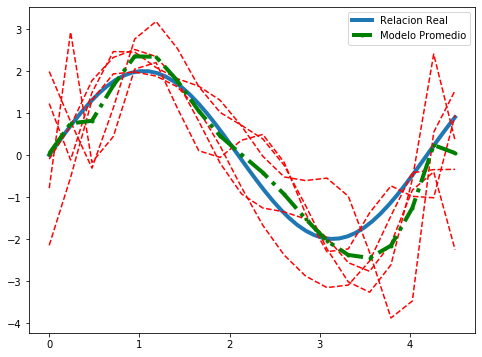

In [36]:
degree = 10
n_samples = 20
n_models = 5
avg_y = np.zeros(n_samples)

plt.figure(figsize = (8,6))
plt.plot(f_x, f_y, label = 'Relacion Real', lw = 4)
for i in range(n_models):
    (x,y) = sample(x_min = 0, x_max = 4.5, size = n_samples)
    model = fit_polynomial(x, y, degree)
    p_y = apply_polynomial(model, x)
    avg_y = avg_y + p_y
    plt.plot(x, p_y, 'r--')
avg_y = avg_y / n_models
plt.plot(x, avg_y, 'g.-.', label = 'Modelo Promedio', lw = 4)
plt.legend()
plt.show()

### Cálculo de sesgo y varianza

Recordemos que el sesgo es el error de que surge de las suposiciones que tiene nuestro modelo. Cuántos más supuestos, menos flexible será. La varianza, en cambio, es el error que surge de la sensibilidad de nuestro modelo a variaciones en el set de entrenamiento. Cuánto más flexible nuestro modelo, más se ajustará a los datos de entrenamiento. Entonces, el sesgo está asociado a modelos *underfiteados*, mientras que la varianza a modelos *overfiteados*. Por lo tanto, la "variable" que controla si nuestro modelo estará sesgado o sufrirá de mucha varianza es su complejidad. Por eso, decimos que hay un trade-off entre ambos errores.

Notar que, para hablar de sesgo y varianza, consideramos que tenemos muchos modelos. Esto no suele ser así en la aplicación. La pregunta que debemos hacernos es: si entrenara muchas veces este mismo modelo, pero con variaciones en el dataset, ¿cuánto espero que varíe mi modelo? Si varía mucho, probablemente tenga mucha varianza y, por lo tanto, esté overfiteado. Si varía muy poco o directamente no varía, probablemente esté sesgado y underfiteado.

Pero, ¿cómo se calculan ambos errores? Podemos calcular la varianza como cuánto varía en promedio el output de cada modelo entrenado con respecto al promedio de todos los modelos entrenados. Parece un trabalenguas. El sesgo, en cambio, es cuánto se desvía la salida del promedio de los modelos con respecto al verdero output.

Veámoslo en el código. Al igual que en el ejemplo anterior, generamos varias muestras y ajustamos un polinomio a cada una. Calculamos el sesgo y la varianza entre los modelos para diferentes grados polinómicos. El sesgo, la varianza y el error se grafican para diferentes valores de grado.

**Ejercicio:** leer detenidamente las siguientes lineas de código. Prestar atención a qué variable recorre cada `for` y qué se calcula dentro de cada bucle. Comentar el código a medida que comprendan cada paso del mismo.

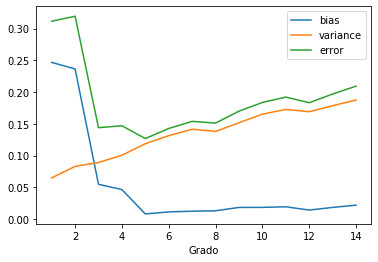

In [37]:
from numpy.linalg import norm

n_samples = 20

f_x = np.linspace(0, 4.5, n_samples)
f_y = 2 * np.sin(x * 1.5)

n_models = 100
max_degree = 15
var_vals =[]
bias_vals = []
error_vals = []

for degree in range(1, max_degree):
    avg_y = np.zeros(n_samples)
    models = []
    for i in range(n_models):
        (x,y) = sample(0,4.5, n_samples)
        model = fit_polynomial(x, y, degree)
        p_y = apply_polynomial(model, x)
        avg_y = avg_y + p_y
        models.append(p_y)
    avg_y = avg_y / n_models
    bias_2 = np.linalg.norm(avg_y - f_y)/f_y.size
    bias_vals.append(bias_2)
    variance = 0
    for p_y in models:
        variance += np.linalg.norm(avg_y - p_y)
    variance /= f_y.size * n_models
    var_vals.append(variance)
    error_vals.append(variance + bias_2)

    
### Graficamos
plt.plot(range(1, max_degree), bias_vals, label='bias')
plt.plot(range(1, max_degree), var_vals, label='variance')
plt.plot(range(1, max_degree), error_vals, label='error')
plt.xlabel('Grado')
plt.legend()
plt.show()